In [1]:
import h5py
import math
import bisect
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
matplotlib.font_manager._rebuild()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
from IPython.display import set_matplotlib_formats
from IPython.display import display, Latex
set_matplotlib_formats('png', 'pdf')
import seaborn as sns

In [2]:
class Data:
    def __init__(self, file):
        self.x = np.array(file['BubbleScale/Variable'])
        self.imagx = np.array(file['BubbleScale/Imag'])
        self.realx = np.array(file['BubbleScale/Real'])
        self.imagDeriv = np.array(file['BubbleScale/ImagDeriv'])
        self.alpha = file['BubbleScale'].attrs['alphaT']
                
        self.aPos = file['SelfEnergy'].attrs['aPos']
        self.aNeg = file['SelfEnergy'].attrs['aNeg']
        self.M = file['SelfEnergy'].attrs['M']
        self.N = file['SelfEnergy'].attrs['N']
        self.v = file['SelfEnergy'].attrs['v']
        self.b = file['SelfEnergy'].attrs['b']
        
        self.etaOmega = self.M/(self.N*math.pi)*(self.aPos+self.aNeg)
        
        self.arpos = np.array(file['SelfEnergyRadial/arPos'])
        self.arneg = np.array(file['SelfEnergyRadial/arNeg'])
        self.radInterPos = np.array(file['SelfEnergyRadial/radInterPos'])
        self.radInterNeg = np.array(file['SelfEnergyRadial/radInterNeg'])
        
        self.kr = np.array(file['SelfEnergyRadial/kr'])
        self.radSePos = np.array(file['SelfEnergyRadial/seRadPos'])
        self.radSeNeg = np.array(file['SelfEnergyRadial/seRadNeg'])
        
        self.integrand = self.arneg - self.arpos + self.aPos - self.aNeg

        self.negKr = -self.kr[::-1]
        self.fullK = np.concatenate((self.negKr,self.kr))
        self.fullSe = np.concatenate((self.radSeNeg[::-1],self.radSePos))
        
        def etaPos(self):
            logKr = np.log(self.kr)
            posRatio = self.radSePos/self.kr
            slope, intercept, r, p, std_err = stats.linregress(logKr, posRatio)
            return -slope
        
        def etaNeg(self):
            logKr = np.log(self.kr)
            negRatio = -self.radSeNeg/self.kr
            slope, intercept, r, p, std_err = stats.linregress(logKr, negRatio)
            return -slope
        
        self.etaRPlus = etaPos(self)
        self.etaRMinus = etaNeg(self)
        
        
        self.ktilde = np.array(file['SelfEnergyTangential/ktilde'])
        self.atPos = np.array(file['SelfEnergyTangential/atPos'])
        self.atNeg = np.array(file['SelfEnergyTangential/atNeg'])
        self.interk = np.array(file['SelfEnergyTangential/interk'])
        self.subtractPos = np.array(file['SelfEnergyTangential/subtractPos'])
        self.subtractNeg = np.array(file['SelfEnergyTangential/subtractNeg'])
        self.freqs = np.array(file['SelfEnergyTangential/freqs'])
        self.freqPos = np.array(file['SelfEnergyTangential/freqPos'])
        self.freqNeg = np.array(file['SelfEnergyTangential/freqNeg'])
        self.Dpos = file['SelfEnergyTangential'].attrs['DPos']
        self.Dneg = file['SelfEnergyTangential'].attrs['DNeg']
        
        self.kt = np.array(file['SelfEnergyTangential/kt'])
        self.seTang = np.array(file['SelfEnergyTangential/seTang'])
        
        self.ktAlpha = self.kt**self.alpha
        
        def tangentialSeCoefficient(self):
            slope, intercept, r, p, std_err = stats.linregress(self.ktAlpha, self.seTang)
            return slope
            
        self.uAlpha = tangentialSeCoefficient(self)
        
        def etaTangential(self):
            logKt = np.log(self.kt**4)
            tangRatio = self.seTang/self.kt**4
            slope, intercept, r, p, std_err = stats.linregress(logKt, tangRatio)
            return -slope
        
        self.etaTang = etaTangential(self)

In [3]:
class ScalingPlots(Data):
    def __init__(self,file):
        Data.__init__(self,file)
        
# explicit evaluation of imaginary part
    def imagPlot(self):
        def f(x):
            if(x<1/8):
                return 0.0
            else:
                return -1.0/(2.0*math.pi)*math.sqrt(2*math.sqrt(2*(1+x))-3)
        f2 = np.vectorize(f)
        x = np.linspace(self.x[0], self.x[-1], 5000)
        plt.plot(x, f2(x),label='Exact result')
        
        plt.plot(self.x,self.imagx,label='Numerics',linestyle='dashed')
        plt.xlabel(r'$x$',fontsize=20)
        plt.ylabel(r'$ImI_{\alpha}(x)$',fontsize=20)
        plt.xlim([self.x[0],self.x[-1]])
        plt.ylim([-0.5,0.2])
        #plt.axvline(0.0,linewidth=1,color='black',linestyle='--')
        plt.legend()
        plt.show()
  
    def imagDerivPlot(self):
        def f(x):
            if(x<1/8):
                return 0.0
            else:
                return -1.0/(2.0*math.pi*math.sqrt(2*(1+x))*math.sqrt(2*math.sqrt(2*(1+x))-3))
        f2 = np.vectorize(f)
        x = np.linspace(self.x[0], self.x[-1], 5000)
        plt.plot(x, f2(x),label='Exact result')
        
        plt.plot(self.x,self.imagDeriv,label='Numerics',linestyle='dashed')
        plt.xlabel(r'$x$',fontsize=20)
        plt.ylabel(r'$\frac{d}{dx}ImI_{\alpha}(x)$',fontsize=20)
        plt.xlim([self.x[0],self.x[-1]])
        plt.ylim([-0.5,0.2])
        #plt.axvline(0.0,linewidth=1,color='black',linestyle='--')
        plt.legend()
        plt.show()

    def realPlot(self):
        def f(x):
            if(x<1/8):
                return 1.0/(math.pi)*math.sqrt(3/2+math.sqrt(1/4-2*x))
            else:
                return 1.0/(2.0*math.pi)*math.sqrt(2*math.sqrt(2*(1+x))+3)
        f2 = np.vectorize(f)
        x = np.linspace(self.x[0], self.x[-1], 5000)
        plt.plot(x, f2(x),label='Exact result')
        
        plt.plot(self.x,self.realx,label='Numerics',linestyle='dashed')
        plt.xlabel(r'$x$',fontsize=20)
        plt.ylabel(r'$ReI_{\alpha}(x)$',fontsize=20)
        #plt.xlim([-0.2,0.2])
        #plt.ylim([-0.5,0.2])
        #plt.axvline(0.0,linewidth=1,color='black',linestyle='--')
        plt.legend()
        plt.show()
            
    def radPosPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.arpos)
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_+(\tilde{k}_r)$',fontsize=20)
        ax.axvline(-1.0, linestyle='--', color='black')
        plt.show()
        
    def radNegPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.arneg)
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_-(\tilde{k}_r)$',fontsize=20)
        ax.axvline(1.0, linestyle='--', color='black')
        plt.show()
       
    def radPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.arpos,linewidth=2,label=r'$A^{(r)}_+$')
        plt.plot(self.x,self.arneg,linewidth=2,label=r'$A^{(r)}_-$')
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_{\pm}(\tilde{k}_r)$',fontsize=20)
        ax.axvline(-1.0,linewidth=1, linestyle='--', color='black')
        ax.axvline(1.0,linewidth=1, linestyle='--', color='black')
        plt.xlim([-5,5])
        #plt.ylim([0.0,0.15])
        plt.legend(fontsize=15)
        plt.savefig('Graphics/radScale.pdf',bbox_inches="tight")
        plt.show()
        
    def integrandPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.integrand)
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$f(\tilde{k}_r)$',fontsize=20)
        plt.xlim([0,5])
        plt.show()
        
    def radInterPosPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.radInterPos)
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_+(\tilde{k}_r)$',fontsize=20)
        ax.axvline(-1.0, linestyle='--', color='black')
        plt.show()  
        
    def radInterNegPlot(self):
        ax = plt.gca()
        plt.plot(self.x,self.radInterNeg)
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_+(\tilde{k}_r)$',fontsize=20)
        ax.axvline(1.0, linestyle='--', color='black')
        plt.show()  
        
    def seradPosPlot(self):
        plt.plot(self.kr,self.radSePos)
        plt.xlabel(r'$k_r$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_r)$',fontsize=20)
        plt.show()   
        
    def seradNegPlot(self):
        plt.plot(-self.kr,self.radSeNeg)
        plt.xlabel(r'$k_r$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_r)$',fontsize=20)
        plt.show()   
        
    def seRadPlot(self):
        plt.plot(self.fullK,self.fullSe)
        plt.xlabel(r'$k_r$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_r)$',fontsize=20)
        plt.show()
        
    def seradPosLogPlot(self):
        plt.plot(self.kr,self.radSePos/self.kr)
        plt.xlabel(r'$k_r$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_r)/k_r$',fontsize=20)
        plt.xscale('log')
        #plt.savefig('Graphics/seRadPosQuartic.pdf',bbox_inches="tight")
        plt.show()   
        
    def seradNegLogPlot(self):
        plt.plot(self.kr,-self.radSeNeg/self.kr)
        plt.xlabel(r'$-k_r$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_r)/k_r$',fontsize=20)
        #plt.xlim([-1.0,-1e-4])
        plt.xscale('log')
        #plt.savefig('Graphics/seRadNegQuartic.pdf',bbox_inches="tight")
        plt.show()   
        
    def tangPosPlot(self):
        plt.plot(self.ktilde,self.atPos)
        plt.xlabel(r'$\tilde{k}_t$',fontsize=20)
        plt.ylabel(r'$A^{(t)}_+(\tilde{k}_t)$',fontsize=20)
        plt.show()
        
    def tangNegPlot(self):
        plt.plot(self.ktilde,self.atNeg)
        plt.xlabel(r'$\tilde{k}_t$',fontsize=20)
        plt.ylabel(r'$A^{(t)}_-(\tilde{k}_t)$',fontsize=20)
        plt.show()
       
    def tangPlot(self):
        plt.plot(self.ktilde,self.atPos,linewidth=2,label=r'$A^{(t)}_+$')
        plt.plot(self.ktilde,self.atNeg,linewidth=2,label=r'$A^{(t)}_-$')
        plt.xlabel(r'$\tilde{k}_t$',fontsize=20)
        plt.ylabel(r'$A^{(t)}_{\pm}(\tilde{k}_t)$',fontsize=20)
        #plt.xlim([0,5])
        #plt.ylim([0.0,0.15])
        plt.axvline(1.0,linestyle='--',color='black')
        plt.legend()
        plt.show()
     
    def subtractPlot(self):
        plt.plot(self.interk,self.subtractPos,linewidth=2,label=r'\delta A^{(t)}_+$')
        plt.plot(self.interk,self.subtractNeg,linewidth=2,label=r'\delta A^{(t)}_-$')
        plt.xlabel(r'$\tilde{k}_t$',fontsize=20)
        plt.ylabel(r'$\delta A^{(t)}_{\pm}(\tilde{k}_t)$',fontsize=20)
        #plt.legend(fontsize=15)
        plt.show()
        
    def tangFrequency(self):
        plt.scatter(self.freqs,self.freqPos,s=1,label=r'$f_+(\omega)$')
        plt.scatter(self.freqs,self.freqNeg,s=1,label=r'$f_-(\omega)$')
        plt.xlabel(r'$\omega$',fontsize=20)
        plt.ylabel(r'$f_\pm(\omega)$',fontsize=20)
        plt.ylim([-0.05,0.25])
        plt.legend(fontsize=15)
        plt.show()
        display(Latex(f"$D_+ =$" + str(round(self.Dpos,4))))
        display(Latex(f"$D_- =$" + str(round(self.Dneg,4))))
    
    def tangSubtractFrequency(self):
        plt.scatter(self.freqs,self.freqNeg-self.freqPos,s=1)
        plt.xlabel(r'$\omega$',fontsize=20)
        plt.ylabel(r'$\delta f(\omega)$',fontsize=20)
        plt.ylim([-0.05,1])
        plt.show()
    
    def seTangPlot(self):
        plt.plot(self.kt,self.seTang)
        plt.xlabel(r'$k_t$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_t)$',fontsize=20)
        #plt.savefig('Graphics/seTangLinear4.pdf',bbox_inches="tight")
        plt.show()
        
    def seTangDividePlot(self):
        plt.plot(self.kt**4,self.seTang/(self.kt**4))
        plt.xlabel(r'$k_t^4$',fontsize=20)
        plt.ylabel(r'$\frac{Re\delta\Sigma(k_t)}{k_t^4}$',fontsize=20)
        plt.xscale('log')
        #plt.xlim([1e-8,1e-4])
        #plt.savefig('Graphics/tangLogQuartic4.pdf',bbox_inches="tight")
        display(Latex(f"$D_+ =$" + str(round(self.Dpos,4))))
        display(Latex(f"$D_- =$" + str(round(self.Dneg,4))))
        display(Latex(r"$\eta_t =$" + str(round(self.etaTang,4))))
        plt.show()
        
    def seTangQuarticPlot(self):
        plt.plot(self.kt**4,self.seTang)
        plt.xlabel(r'$k_t^4$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_t)$',fontsize=20)
        #plt.savefig('Graphics/seTangQuartic4.pdf',bbox_inches="tight")
        plt.show()
        
    def seTangAlphaPlot(self):
        plt.plot(self.kt**self.alpha,self.seTang)
        plt.xlabel(r'$k_t^\alpha$',fontsize=20)
        plt.ylabel(r'$Re\delta\Sigma(k_t)$',fontsize=20)
        plt.show()

In [4]:
foo = ScalingPlots(h5py.File('expandedTang400.h5','r'))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


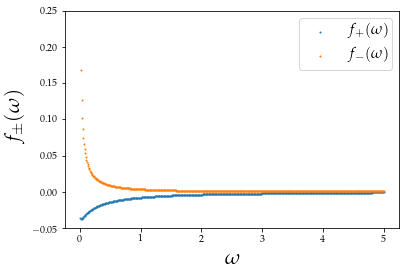

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
foo.tangFrequency()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

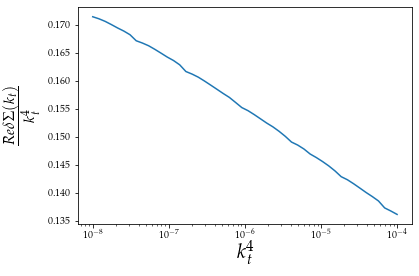

In [6]:
foo.seTangDividePlot()

In [8]:
foo.N

2.0

In [10]:
foo.etaTang*foo.N/foo.M

0.002610511299813035

In [18]:
(0.0037+0.005)/math.pi

0.0027692960097989786

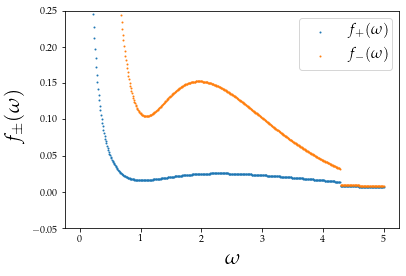

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in subtract


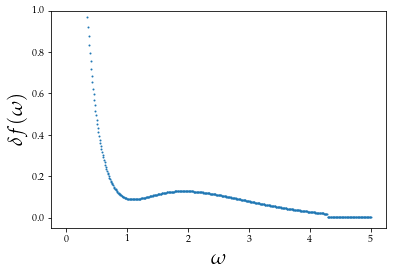

In [7]:
ScalingPlots(h5py.File('expandedTang210.h5','r')).tangFrequency()
ScalingPlots(h5py.File('expandedTang210.h5','r')).tangSubtractFrequency()

In [49]:
ScalingPlots(h5py.File('expandedTang220.h5','r')).uAlpha

2.2039621260072324

In [8]:
import glob

file_list = glob.glob('expandedTang*.h5')
file_list.sort()

In [9]:
alpha = []
u = []
DPos = []
DNeg = []
for file_name in file_list:
    foo = ScalingPlots(h5py.File(file_name,'r'))
    alpha.append(foo.alpha)
    u.append(foo.uAlpha)
    DPos.append(foo.Dpos)
    DNeg.append(foo.Dneg)

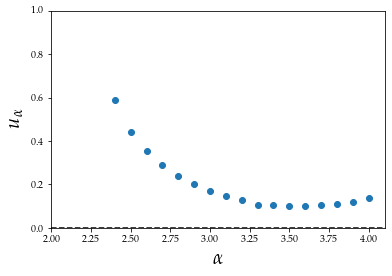

In [10]:
plt.scatter(alpha,u)
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$u_{\alpha}$',fontsize=20)
plt.axhline(0.0,linestyle='--',color='black')
plt.ylim([0.0,1])
plt.savefig('Graphics/tangentialCoefficient.pdf',bbox_inches="tight")
plt.show()

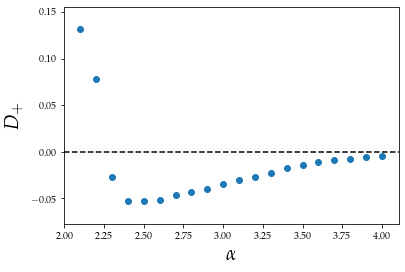

In [54]:
plt.scatter(alpha,DPos)
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$D_+$',fontsize=20)
plt.axhline(0.0,linestyle='--',color='black')
#plt.savefig('Graphics/tangentialCoefficient.pdf',bbox_inches="tight")
plt.show()

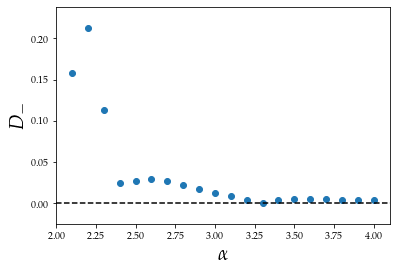

In [55]:
plt.scatter(alpha,DNeg)
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$D_-$',fontsize=20)
plt.axhline(0.0,linestyle='--',color='black')
#plt.savefig('Graphics/tangentialCoefficient.pdf',bbox_inches="tight")
plt.show()